# eCommerce Example

This notebook details a time series analysis and forecasting application performed with scalecast using the eCommerce dataset. The notebook starts with an exploratory data analysis; moves to time series decomposition; forecasts with an exponential smoothing model; an ARIMA model; a multiple linear regression model; moves to automated forecasting with scikit-learn models, Facebook Prophet, and LinkedIn Greykite/Silverkite; explores TensorFlow recurrent neural nets; and finally finishes with combination modeling.

The utilized dataset is available on kaggle: https://www.kaggle.com/carrie1/ecommerce-data/

[Library Imports](#Library-Imports)  
[Exploratory Data Analysis](#Exploratory-Data-Analysis)  
[Forecast with scalecast](#Forecast-with-Scalecast)  

  - [Holt-Winters Exponential Smoothing](#HWES)  
  - [ARIMA](#ARIMA)  
  - [MLR](#MLR)  
  - [Elasticnet and Auto-Forecasting](#Elasticnet-and-Auto-Forecasting)  
  - [Auto-Forecasting the Scikit-learn Models](#Auto-Forecasting-the-Scikit-learn-Models)  
  - [Prophet and Silverkite](#Prophet-and-Silverkite)  
  - [TensorFlow Recurrent Neural Nets](#TensorFlow-Recurrent-Neural-Nets)  
    - [SimpleRNN](#SimpleRNN)  
    - [LSTM](#LSTM)  
  - [Combination Modeling](#Combination-Modeling)  

[Export Results](#Export-Results)  

## Library Imports
[Back to top](#eCommerce-Example)  
First, let's import the libraries and read the data. Some data preprocessing in pandas will be necessary before calling scalecast.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scalecast.Forecaster import Forecaster
from scalecast import GridGenerator
from scalecast.notebook import tune_test_forecast

In [2]:
data = pd.read_csv('eCommerce.csv',parse_dates=['InvoiceDate'], encoding = 'unicode_escape')

In [3]:
sns.set(rc={'figure.figsize':(15,7)})

## Exploratory Data Analysis

[Back to top](#eCommerce-Example)  
Let's view the data's first five rows.

In [4]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Now, let's view the data's dimensions.

In [5]:
data.shape

(541909, 8)

Let's see how much time these 550,000 observations span.

In [6]:
print('first date in data:',data['InvoiceDate'].min())
print('last date in data:',data['InvoiceDate'].max())

first date in data: 2010-12-01 08:26:00
last date in data: 2011-12-09 12:50:00


In spite of there being over half a million rows, there is only about a year's worth of data to analyze. Before proceding, we should decide a datetime frequency to aggregate the data to, otherwise we will be trying to forecast with an incosistent interval of time between observations. This decision depends on what question we are trying to answer. For this example, let's try answering the question of if we can accurately predict daily gross sales revenues in the United Kingdom over 30 days. This means we will be removing sales that were negative in value (probably representing returns), creating a "Sales" column by multiplying quantity by price, and aggregating the entire dataframe to the daily level. Then, we subset to `country=='United Kingdom'` and fill any days that show no sales with 0.

In [7]:
# drop negative sales quantities
data = data.loc[(data['Quantity'] > 0) & (data['Country'] == 'United Kingdom')]
# create the Sales column
data['Sales'] = data['Quantity']*data['UnitPrice']
# aggregate the dataframe to the daily level
dt_aggr = 'D'
data['DateTime'] = data['InvoiceDate'].dt.floor(dt_aggr)
tbl = data.groupby('DateTime')['Sales'].sum().reset_index()
# view first 5 rows
tbl.head()

,DateTime,Sales
0,2010-12-01,54818.08
1,2010-12-02,47570.53
2,2010-12-03,41308.69
3,2010-12-05,25853.20
4,2010-12-06,53322.12


In [8]:
tbl.shape

(305, 2)

In [9]:
print('first date in data:',tbl['DateTime'].min())
print('last date in data:',tbl['DateTime'].max())

first date in data: 2010-12-01 00:00:00
last date in data: 2011-12-09 00:00:00


It is possible that after making this aggregation to the daily level, some date observations in the range are missing. Some forecasting libraries will process missing data for you automatically, but because scalecast mixes so many model concepts, it is necessary to have every possible date in a given range represented. If we run the code below, we will limit the dataframe to only days and any missing dates will have their sales filled with 0.

In [10]:
all_dates = pd.DataFrame({'DateTime':pd.date_range(start=tbl['DateTime'].min(),end=tbl['DateTime'].max(),freq=dt_aggr)})
full_data = all_dates.merge(tbl,on='DateTime',how='left').sort_values(['DateTime']).fillna(0)
full_data.head()

,DateTime,Sales
0,2010-12-01,54818.08
1,2010-12-02,47570.53
2,2010-12-03,41308.69
3,2010-12-04,0.00
4,2010-12-05,25853.20


Let's see how that looks plotted.

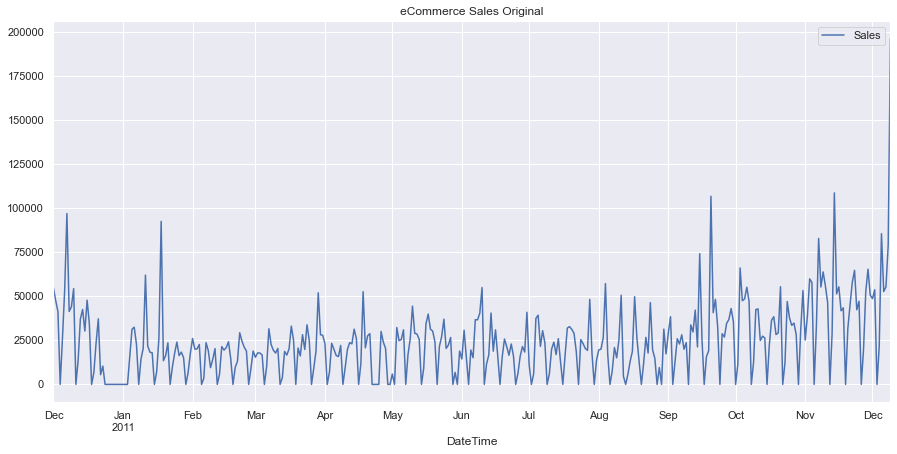

In [11]:
full_data.plot(x='DateTime',y='Sales',title='eCommerce Sales Original')
plt.show()

We notice the last observation in the dataframe is an outlier. Let's look at it more closely.

In [12]:
full_data.sort_values(['Sales'],ascending=False).head(1)

,DateTime,Sales
373,2011-12-09,196134.1


There are different ways to handle outliers in time series, but we will try ignoring it to see how well our models can predict it.

The last preprocessing function we want to perform is removing the first month or so of observations because so many of them are 0 or close-to-0 in value. Starting January 4, 2011, we see a more normal pattern.

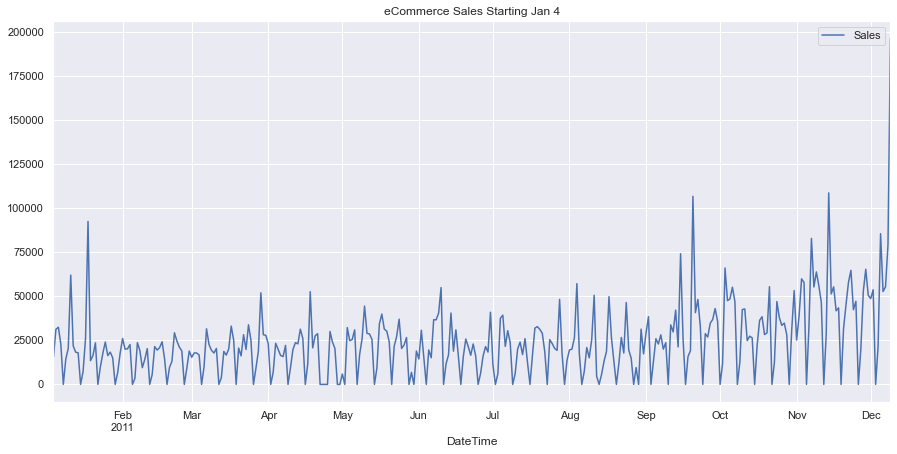

In [13]:
full_data = full_data.loc[full_data['DateTime'] >= datetime.datetime(2011,1,4)]
full_data.plot(x='DateTime',y='Sales',title='eCommerce Sales Starting Jan 4')
plt.show()

Much better. In the real world, we might want to know more about that outlier -- why it exists, the best way to mitigate it, etc. This example is more interested in producing forecasts and showing the scalecast process, so we are going to do a very simple mitigation strategy -- cap the outlier at the next highest value.

In [16]:
full_data.iloc[-1,1] = full_data.iloc[:-1,:]['Sales'].max()

Let's now try to get a better idea of how the data is distributed.

In [17]:
full_data.describe()

,Sales
count,340.000000
mean,24021.396541
std,19121.458716
min,0.000000
25%,12518.370000
50%,21182.990000
75%,31394.397500
max,108579.940000


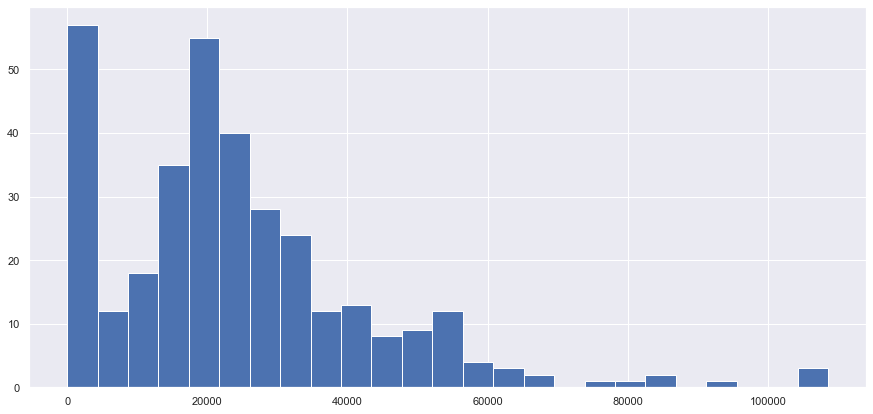

In [18]:
full_data['Sales'].hist(bins=25)
plt.show()

The remaining data looks somewhat normally distributed with a slight right skew.

## Forecast with Scalecast
[Back to top](#eCommerce-Example)  
To load the object, we call the Forecaster() function with the `y` and `current_dates` parameters specified. If we hadn't already dropped the first observations of the data before calling the object, we could have done it by using the `keep_smaller_history()` function as shown below. We can then plot the values that we will be using for forecasting.

In [19]:
f = Forecaster(y=full_data['Sales'],current_dates=full_data['DateTime'])
f

Forecaster(
    DateStartActuals=2011-01-04T00:00:00.000000000
    DateEndActuals=2011-12-09T00:00:00.000000000
    Freq=D
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
)

The first thing you should do after initializing the object is set its test length. What that length is is up to you. The longer the length, the more confident you can be about your reported error/accuracy metrics. The library requires a test length of at least 1. Let's set our test length to be the same size as our forecast length: 30 days.

In [20]:
f.set_test_length(30)

Before beginning the forecasting process, we should get a better idea of the signals within the time series itself. Using ACF, PACF, and Periodogram plots, we can observe how the series is auto-correlated. We leave the test set out of all visualizations (`train_only=True`) to not leak data when making decisions about which signals exist in the data.

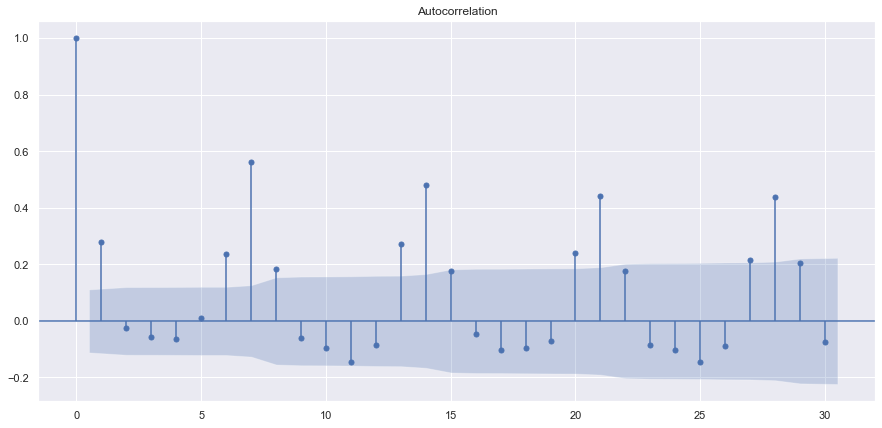

In [21]:
f.plot_acf(train_only=True,lags=30)
plt.show()

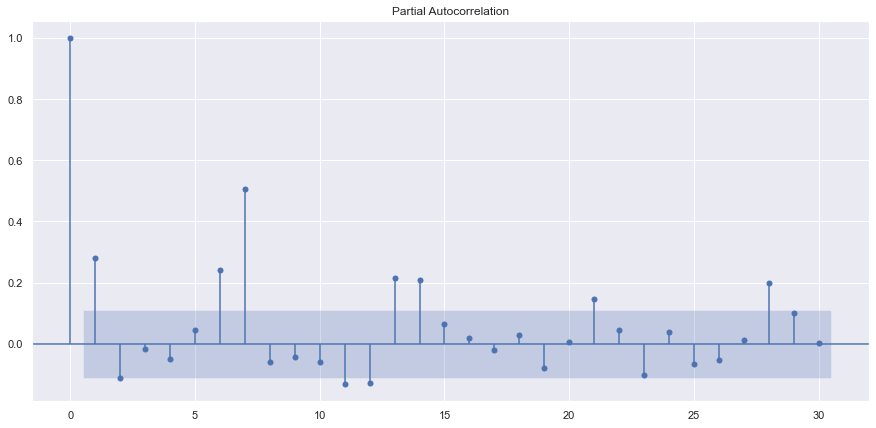

In [22]:
f.plot_pacf(train_only=True,lags=30)
plt.show()

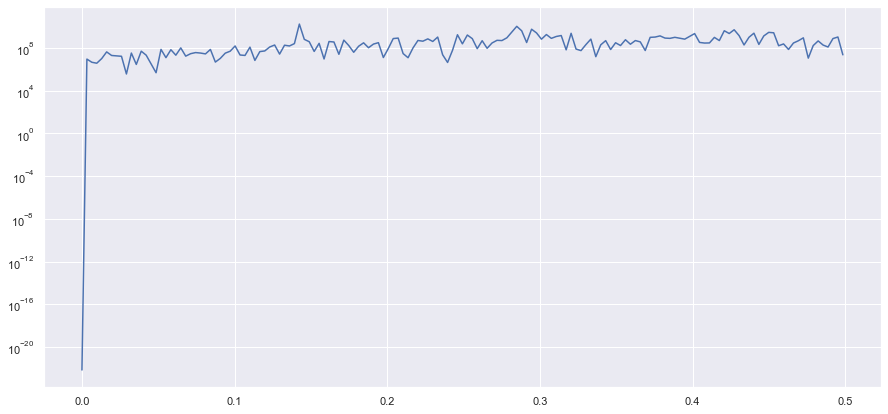

In [23]:
a, b = f.plot_periodogram(diffy=True,train_only=True)
plt.semilogy(a, b)
plt.show()

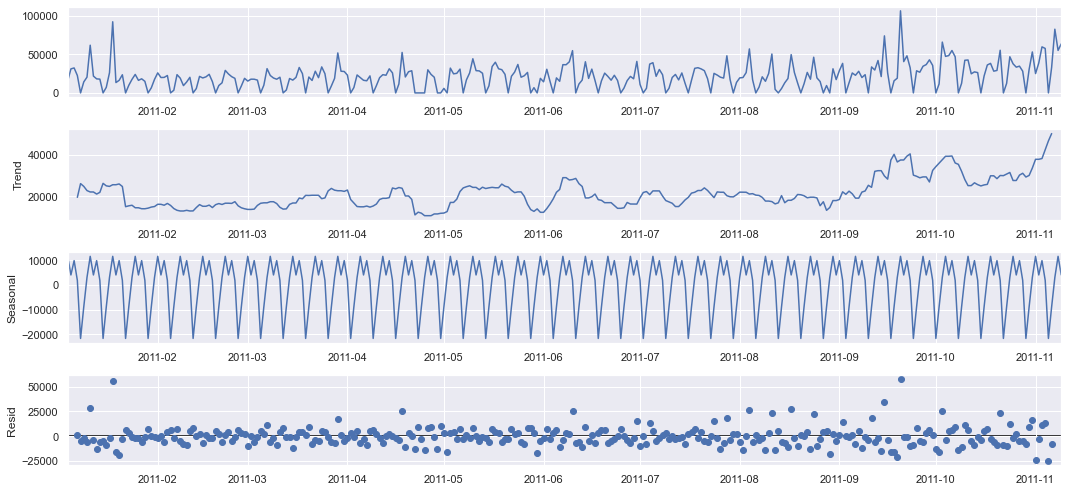

In [24]:
f.seasonal_decompose(train_only=True).plot()
plt.show()

From these graphs, we get a sense that the data has a seasonal pattern over seven periods, or one week. The data appears to be significantly autocorrelated back 1, 6, 7, and 13, and 14 periods, possibly more. This is good information to use when deciding how to specify the forecasts. 

Now, let's test the data's stationarity using the Augmented Dickey-Fuller test. The null hypothesis of this test is that the data is not stationary. To return the p-val and critical value from this test, pass `full_res=True` as an argument. The way we have the test specified, it will simply print out the implications from the test.

In [25]:
isstationary = f.adf_test(quiet=False)

series might not be stationary


Since our test implies non-stationarity, let's view all these plots again, but pass differenced data into them by using the `diffy=1` argument.

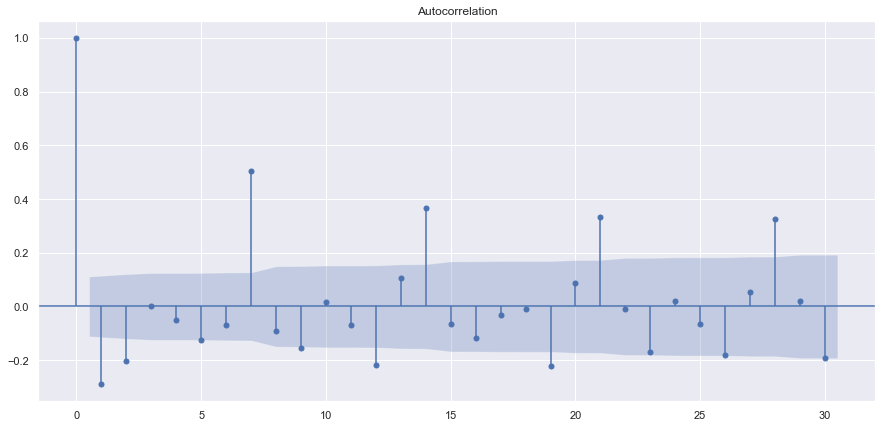

In [26]:
f.plot_acf(diffy=1,train_only=True,lags=30)
plt.show()

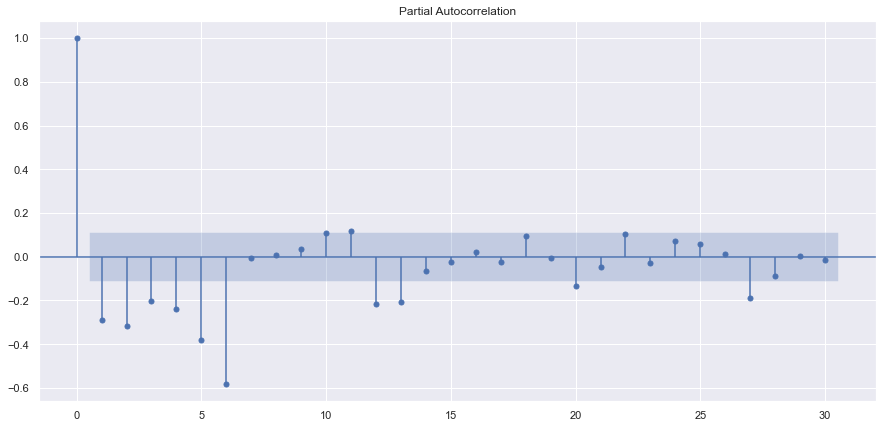

In [27]:
f.plot_pacf(diffy=1,train_only=True,lags=30)
plt.show()

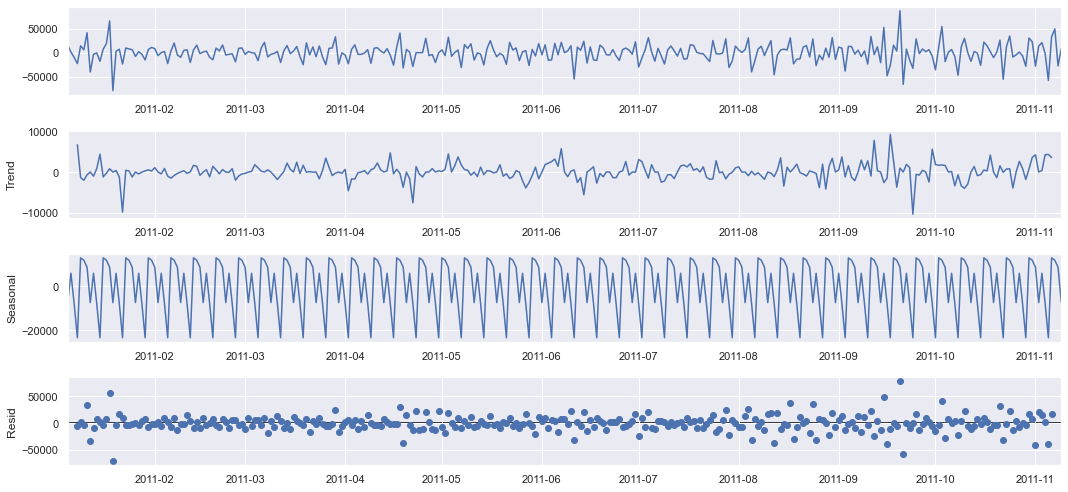

In [28]:
f.seasonal_decompose(diffy=1,train_only=True).plot()
plt.show()

This doesn't give us a very different view of the data, but reinforces that there is strong autocorrelation in our dataset. Some of that can be controlled by using the series' first difference.

You can see below all functions available to plot the information in the object:

In [29]:
print(*f.get_funcs('plotter'),sep='\n')

plot_acf
plot_pacf
plot_periodogram
seasonal_decompose
plot
plot_test_set
plot_fitted


All setter functions:

In [30]:
print(*f.get_funcs('setter'),sep='\n')

set_last_future_date
set_test_length
set_validation_length
set_cilevel
set_bootstrap_samples
set_estimator
set_validation_metric


All getter functions:

In [31]:
print(*f.get_funcs('getter'),sep='\n')

get_regressor_names
get_freq


### HWES
[Back to top](#eCommerce-Example)  
Let's run a couple of exponential smoothing forecasts using Holt-Winters Exponential Smoothing from StatsModels. Most exponential smoothing is considered a somewhat simple way to forecast time series. They are models that smooth out recent trends and predict them to the future. The added benefit of using Holt-Winters is that setting extra parameters to this basic idea, such as seasonality, is possible. We will try one HWES model with seasonality and one without.

Before running any forecast, we need to generate a forecast period. We are attempting to predict 30 days into the future.

In [32]:
f.generate_future_dates(30)

To run an HWES model, we first set the estimator to hwes, then call the `manual_forecast()` function. We can run as many hwes models as we like and differentiate them by using the `call_me` argument. By default, the model will be called whatever the estimator is ("hwes" is "hwes", "arima" is "arima", etc.)

In [33]:
f.set_estimator('hwes')
f.manual_forecast(trend='add')
f.save_summary_stats()

f.manual_forecast(trend='add',seasonal='add',call_me='hwes_seasonal')
f.save_summary_stats()

We can view the results of the model by plotting the test-set predictions with the actual test-set observations, setting ci=True to show 95% confidence intervals. Any confidence level can be set by using `f.setcilevel(...)`. The intervals are evaluated with bootstrapping on the fitted values, and could be different than what is returned from the underlying statsmodels function. This is to make all forecast comparisons consistent across all model types. If the forecast shows tight confidence intervals but are less accurate on the test set, this is a good indication that your model is overfit.

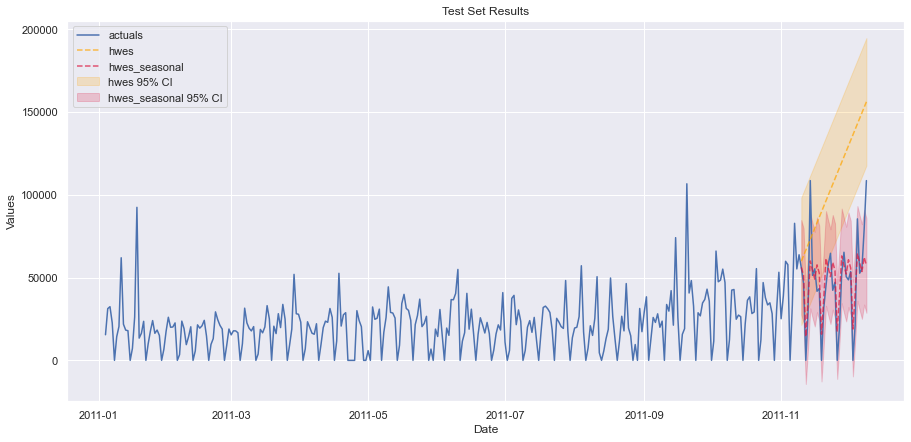

In [34]:
f.plot_test_set(ci=True)

We can see the models' performance over the 30-day forecast horizon as well:

hwes LevelTestSetRMSE: 70168.40359146708
hwes_seasonal LevelTestSetRMSE: 17518.624215169933


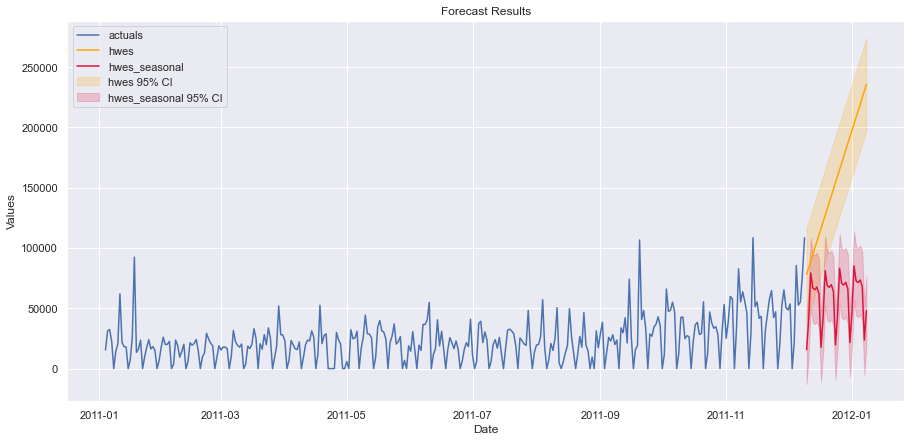

In [35]:
f.plot(print_attr=['LevelTestSetRMSE'],ci=True)

You may have noticed we called a function save_summary_stats() after running each ARIMA model. Most models allow feature information to be saved from them using `save_feature_importance()` or `save_summary_stats()`. Some models don't allow either. They should be called before running a new model because they automatically save that information for the last model run only. As a rule of thumb, saving summary stats is much less computationally expensive than saving feature importance, which will be explored later.

We can see the summary statistics for the better-peforming HWES model exporting the saved summary stats to a dataframe.

In [36]:
f.export_summary_stats(model='hwes_seasonal')

,coeff,code,optimized
smoothing_level,0.111071,alpha,True
smoothing_trend,0.012341,beta,True
smoothing_seasonal,0.197540,gamma,True
initial_level,34879.028000,l.0,True
initial_trend,344.307350,b.0,True
initial_seasons.0,-19400.508000,s.0,True
initial_seasons.1,-3635.737800,s.1,True
initial_seasons.2,-2449.577800,s.2,True
initial_seasons.3,-12222.328000,s.3,True
initial_seasons.4,-34879.028000,s.4,True


### ARIMA
[Back to top](#eCommerce-Example)  
Now, let's run another common, albeit slightly more advanced time-series model: ARIMA. This model uses the series' own history, errors, and stationarity to forecast. Using the output from the plots above, as well as the results from the ADF test, we can specify a 1,1,0 x 1,1,0, as well as a 1,1,1 x 0,1,1, ordered model. The seasonal period will be 7 periods--one week.

In [37]:
f.set_estimator('arima')
f.manual_forecast(order=(1,1,0),seasonal_order=(1,1,0,7))
f.save_summary_stats()

f.manual_forecast(order=(1,1,1),seasonal_order=(0,1,1,7),call_me='arima_ma_terms')
f.save_summary_stats()

We can view the results of the model by plotting the test-set predictions with the actual test-set observations.

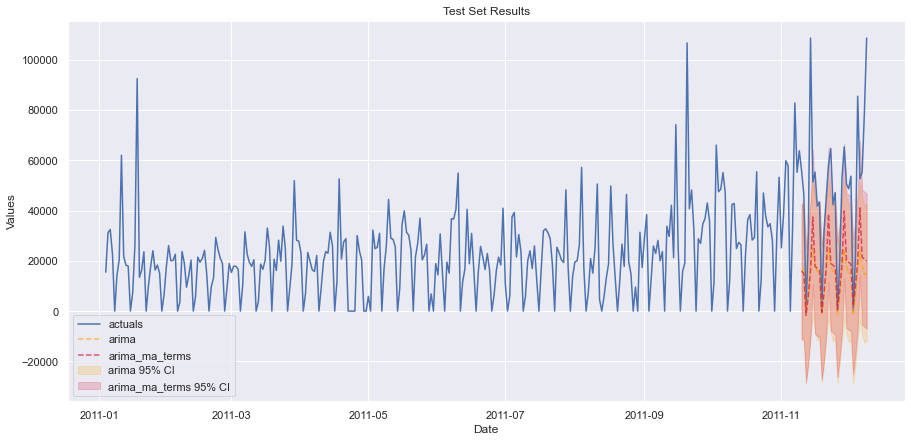

In [38]:
f.plot_test_set(models=['arima','arima_ma_terms'],ci=True)

Those models appear to capture the daily trend fairly well. Let's see how they look into future periods compared to the HWES models previously evaluated.

hwes LevelTestSetRMSE: 70168.40359146708
hwes_seasonal LevelTestSetRMSE: 17518.624215169933
arima LevelTestSetRMSE: 40024.87083460185
arima_ma_terms LevelTestSetRMSE: 37348.542960036495


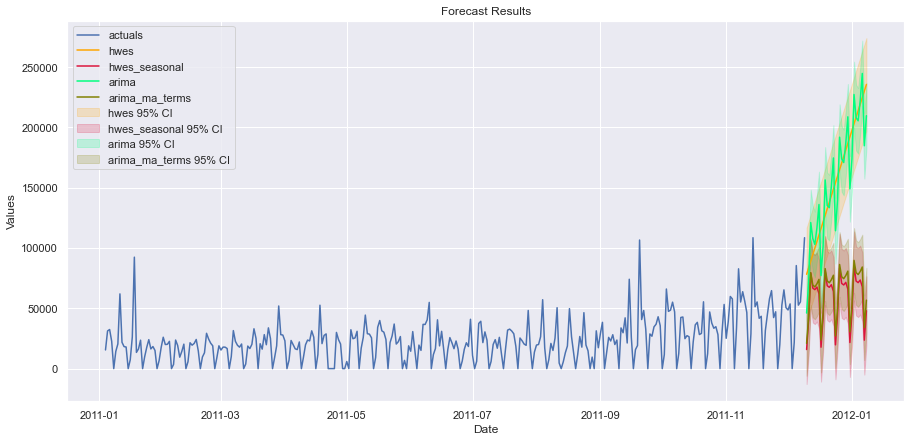

In [39]:
f.plot(print_attr=['LevelTestSetRMSE'],ci=True)

The ARIMA model without MA terms, as well as the hwes model without MA terms, has really gone in a strange direction. These two are also the worst performing models we have evaluated, using the test-set RMSE as our comparison metric. Let's delete both of them from memory.

In [40]:
f.pop('arima','hwes')

We can see the summary statistics for the remaining ARIMA model by exporting the saved summary stats to a dataframe, just like we did for the HWES model.

In [41]:
f.export_summary_stats(model='arima_ma_terms')

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,1.740000e-02,6.300000e-02,2.760000e-01,0.782,-1.060000e-01,1.410000e-01
ma.L1,-8.563000e-01,4.200000e-02,-2.052900e+01,0.000,-9.380000e-01,-7.750000e-01
ma.S.L7,-8.304000e-01,2.600000e-02,-3.227600e+01,0.000,-8.810000e-01,-7.800000e-01
sigma2,1.572000e+08,1.780000e-10,8.810000e+17,0.000,1.570000e+08,1.570000e+08


### MLR
[Back to top](#eCommerce-Example)  
We can use many other models through scalecast. One of the most basic of these is Multiple Linear Regression. Unlike ARIMA, we don't specify orders on this model, but we can add similar regressors, including autoregressive and seasonal terms, as well as a time trend. The MLR works very similarly to the ARIMA model in that it tries to find a linear relationship between all these components and the future. It makes the assumption that the errors in each time period are independent of one another, however. This assumption may be spurious, but the MLR has proven to make accurate predictions on real-world data.

First, let's begin with autoregressive terms, which are lags of the dependent variable values. We can 28 lags to make sure we are capturing all statistically signficant terms.

In [42]:
f.add_ar_terms(28) # 1-28 lags

To account for stationarity, which is done by setting the middle term to 1 in ARIMA, we have to difference our data before modeling with linear regression.

In [43]:
f.diff()

We can confirm the first-differenced data's (probable) stationarity with another ADF test.

In [44]:
isstationary = f.adf_test(quiet=False)

series appears to be stationary


Let's plot its first difference.

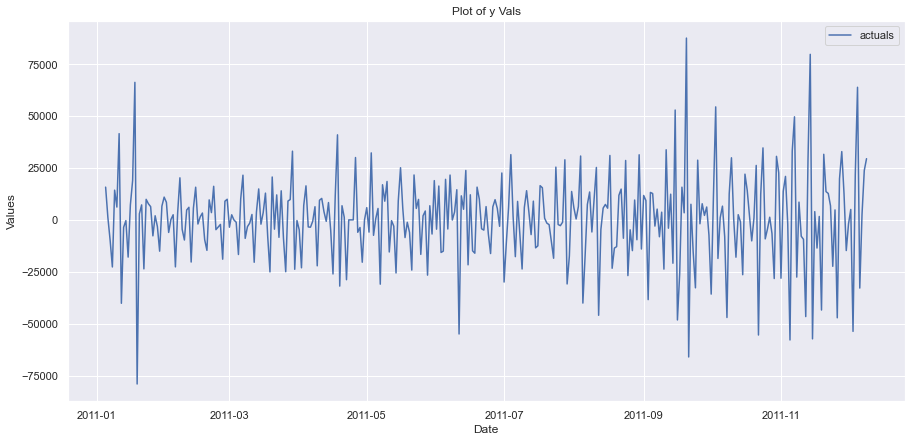

In [45]:
f.plot(models=None)

Let's now add additional seasonality to the model regressors. The main seasonality that we have been able to confirm is weekly, so we can add the 'dayofweek' regressor to our object. We have three options: we can use a sin/cos transformation that accounts for regular fluctuations in the data in a cyclical form; we can add the data as 6-7 dummies using `dummy=True` and specifying the `drop_first` parameter; or we can just use the raw 0-6 numerical output, which is the default (a decision tree model may handle this last kind of regressor better than a linear model). Any decision we make in this regard has its pros and cons. For this example, we will use the dummy transformation. Also, to add complexity that the ARIMA couldn't caputre, we add weekly, monthly, and quarterly seasonality with the sin/cos transformation.

Other seasonal regressors are available and can be specified in the same way, including 'day', 'hour', 'minute' and more.

In [46]:
f.add_seasonal_regressors('dayofweek',raw=False,dummy=True,drop_first=True)
f.add_seasonal_regressors('week','month','quarter',raw=False,sincos=True)

Let's also add a time trend.

In [47]:
f.add_time_trend()

All options for adding regressors are:

In [48]:
print(*f.get_funcs('adder'),sep='\n')

add_ar_terms
add_AR_terms
add_seasonal_regressors
add_time_trend
add_other_regressor
add_covid19_regressor
add_combo_regressors
add_poly_terms
add_exp_terms
add_logged_terms
dd_pt_terms
add_diffed_terms
add_lagged_terms


Let's see what calling our object now that we have evaluated some models looks like.

In [49]:
f

Forecaster(
    DateStartActuals=2011-01-04T00:00:00.000000000
    DateEndActuals=2011-12-09T00:00:00.000000000
    Freq=D
    ForecastLength=30
    Xvars=['AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6', 'weeksin', 'weekcos', 'monthsin', 'monthcos', 'quartersin', 'quartercos', 't']
    Differenced=1
    TestLength=30
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=['hwes_seasonal', 'arima_ma_terms']
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=arima
)

When adding these and other kinds of regressors, it is possible to change the names of some of them. This can come in handy to reference later. If any regressors begin with uppercase "AR", the forecasting mechanisms in most of the models will assume such terms are autoregressive in nature and those terms are handled differently. So, be careful when naming variables.

Let's move to modeling with a linear model. Any arguments that the linear model from the scikit-learn library accepts can also be accepted here. In addition, the following arguments are available for all sklearn models:
- `Xvars` (arguments include "all", None, and list-like objects) -- default is always None, but for models that require regressors, this is treated the same as "all"
- `normalizer` (arguments are None, "minmax", "normalize", "pt", and "scale") -- default is always "minmax"
- `call_me` -- does not affect the model's evaluation at all, just names the model for reference later

In [50]:
f.set_estimator('mlr')
f.manual_forecast(normalizer=None,Xvars=None)

Like the ARIMA model, we can see its performance on the test set. Note that all forecasting in this module, even on the test set, is dynamic in nature so that no training-set information is leaked but autoregressive and seasonal patterns can still be predicted. We can trust that this is a true performance on 20 days of out-of-sample data.

The way the forecasting mechanism works (when AR terms are involved) is by making a prediction one step into the future then filling in those predictions to create new AR terms, until the entire forecast interval has been predicted. This is true for testing and forecasting, but validating is non-dynamic by default. Both validating and testing can be either dynamic or non-dynamic; this will be explored later. With large test, validation, or forecast intervals, the forecasting may slow down considerably if everything is kept dynamic. However, if AR terms have *not* been added to the regressors, forecasting times are similar to any non-time-series prediction application.

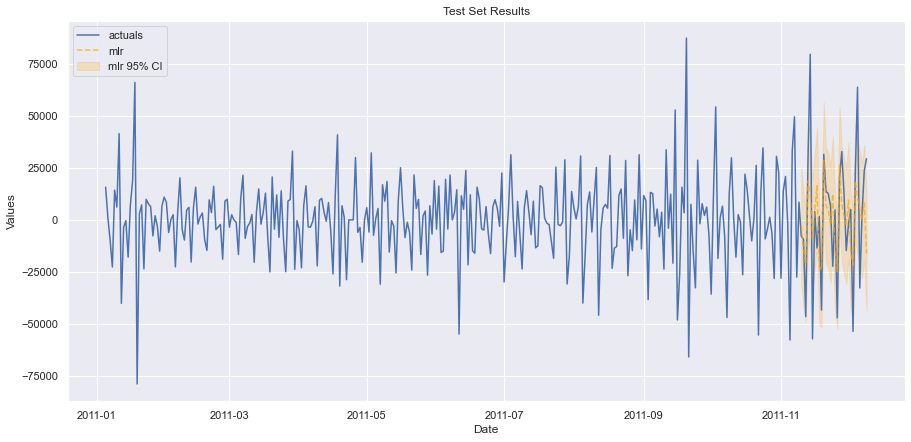

In [51]:
f.plot_test_set(models='mlr',ci=True)

Since the other models were run on level data and the MLR was run on differenced data, to compare them, the plots of the test set and forecasts will revert to level automatically, but `level=True` is available as an argument if all models were run on differenced data but you want to see their performance on the level test set.

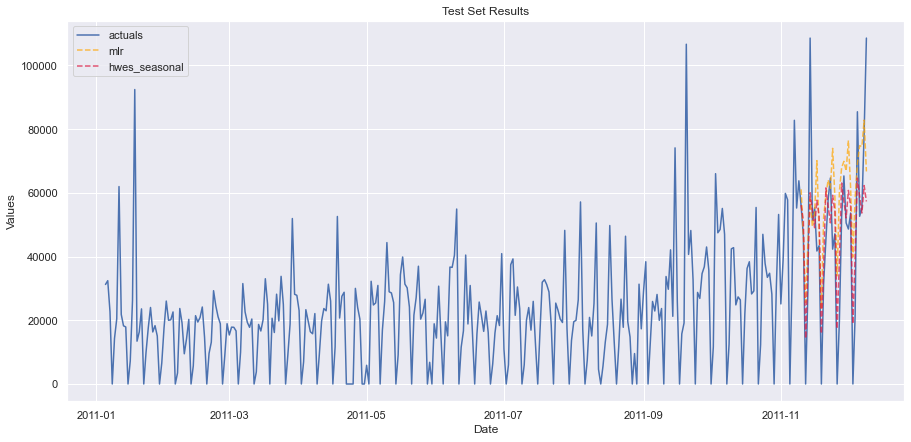

In [52]:
f.plot_test_set(models=['mlr','hwes_seasonal'])

Confidence intervals are no longer available since models were run at different levels.

Let's now plot both models' forecasted values on level data. Let's order the way these models are displayed based on their test-set performance as well.

hwes_seasonal LevelTestSetRMSE: 17518.624215169933
mlr LevelTestSetRMSE: 23569.34929320822
arima_ma_terms LevelTestSetRMSE: 37348.542960036495


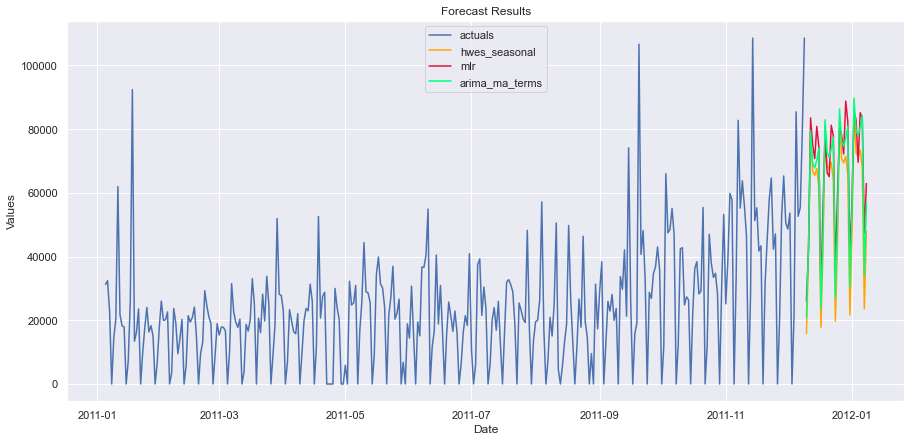

In [53]:
f.plot(print_attr=['LevelTestSetRMSE'],order_by='LevelTestSetRMSE')

We see that the MLR model performed better on the test set than the remaining ARIMA model, but still not as well as the best HWES model.

With scikit-learn models, such as MLR, permutation feature importance information from the [eli5](https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html) package can be saved and exported to a dataframe, analogous to saving summary stats from an ARIMA model. Each weight is the average decrease in accuracy when that particular variable is substituted for random values over 10 iterations, so the variables that cause the largest decreases are considered the most important. The output of the exported data is therefore ranked in terms of which variables are most-to-least important, according to this methodology.

In [54]:
f.save_feature_importance()

In [55]:
f.export_feature_importance(model='mlr')

,weight,std
feature,,
AR1,1.549791,0.071911
AR2,1.270865,0.088312
AR3,0.976237,0.040477
AR4,0.699120,0.026673
AR12,0.550912,0.042243
AR6,0.466184,0.024046
AR5,0.437768,0.013823
AR13,0.328941,0.028640
AR11,0.283812,0.033757


At first glance, it looks as though all added regressors were useful to the MLR model, but we can explore regularization now to further refine our forecasting approach.

### Elasticnet and Auto-Forecasting

[Back to top](#eCommerce-Example)  
To optimize the hyperparameters of and auto-forecast with models in scalecast, we use a grid-search approach on a validation set of data--a period of time before the test set. The grids are completely customizable, but standard template grids are available by calling the function below:

In [56]:
GridGenerator.get_example_grids()

`GridGenerator.get_empty_grids()` is also available. We could call this then open the created file (Grids.py) and fill in the empty dictionary with hyperparameter values that we want to use. The example grids can usually be used for adequate performance, but contributions to improving the default values are welcome. You are also more-than-welcome to open the Grids.py file locally and making adjustments as you see fit.

These grids are saved to your working directory as Grids.py. Their structure is that of `Dict[str:list-like]` and scalecast automatically knows how to look for them. You can also pass your own grid manually by using `ingest_grid()` and passing a `str` value, which corresponds to a namespace of a grid in the Grids.py file, or a grid of `dict` type. By default, the code below will ingest the grid named elasticnet from the Grids.py file in this same directory.

You can also create really big grids and limit them randomly by calling `limit_grid_size(n:int|float)`. If `int`, must be >0 to denote the number of combinations in the grid to keep. If `float`, must be between 0 and 1 to represent a portion of the grid's original size to randomly keep. `random_seed` is available as an argument in this method and is `None` by default.

In [57]:
f.set_validation_length(15)
f.set_estimator('elasticnet')
# unlike testing, tuning is non-dynamic by default, but this can be changed by passing dynamic_tuning=True as an argument below
f.tune() # automatically imports the elasticnet grid from Grids.py
# unlike tuning, testing is dynamic by default, but this can be changed by passing dynamic_testing=False as an argument below
f.auto_forecast()
f.save_feature_importance()

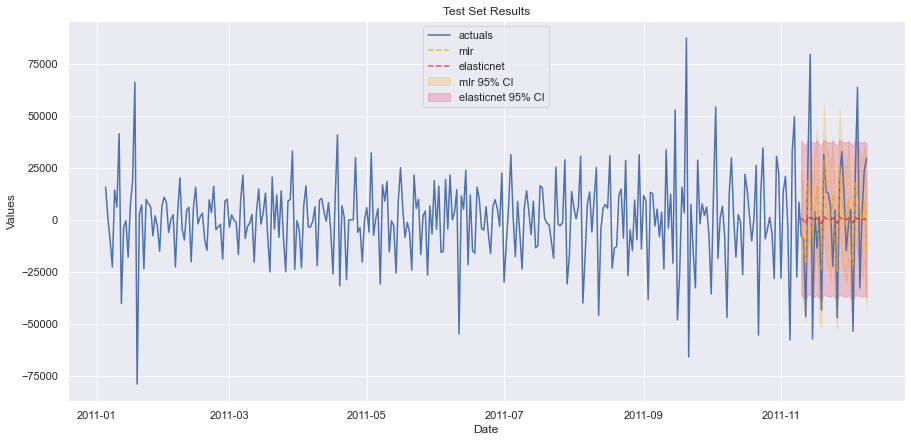

In [58]:
f.plot_test_set(models=['mlr','elasticnet'],ci=True)

Regularization really took the seasonal pattern out of this model and reverted the prediction to nearly a straight line. Let's compare all model forecasts as we did before.

hwes_seasonal LevelTestSetRMSE: 17518.624215169933
mlr LevelTestSetRMSE: 23569.34929320822
elasticnet LevelTestSetRMSE: 32881.360865391776
arima_ma_terms LevelTestSetRMSE: 37348.542960036495


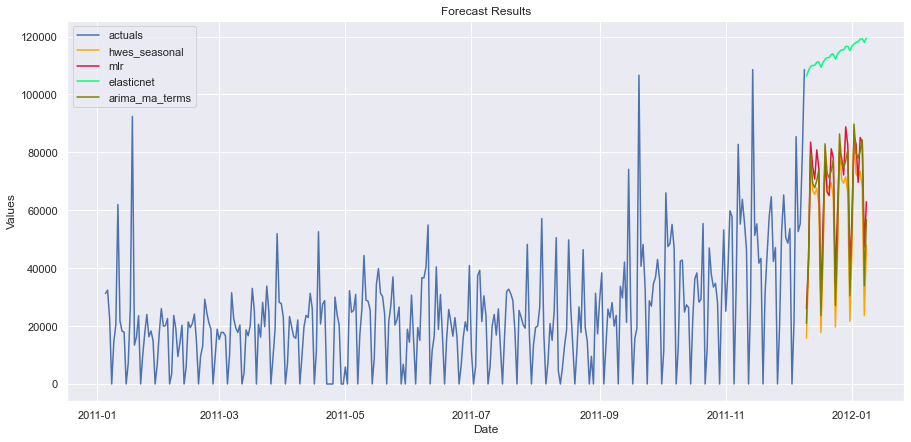

In [59]:
f.plot(print_attr=['LevelTestSetRMSE'],order_by='LevelTestSetRMSE')

In this instance, the regularization performed by the Elasticnet model resulted in worse performance than the MLR. We can see what hyperparameter values were selected from the tuning process by exporting the evaluated validation grid to a dataframe.

In [60]:
f.export_validation_grid(model='elasticnet').sort_values(['metric_value']).head(15)

,alpha,l1_ratio,normalizer,validation_length,validation_metric,metric_value
286,2.0,0.00,minmax,15,rmse,28047.227257
271,1.9,0.00,minmax,15,rmse,28068.118873
256,1.8,0.00,minmax,15,rmse,28091.256243
241,1.7,0.00,minmax,15,rmse,28117.021134
226,1.6,0.00,minmax,15,rmse,28145.886826
289,2.0,0.25,minmax,15,rmse,28178.109481
211,1.5,0.00,minmax,15,rmse,28178.447218
274,1.9,0.25,minmax,15,rmse,28205.401145
196,1.4,0.00,minmax,15,rmse,28215.457771
259,1.8,0.25,minmax,15,rmse,28235.588063


Since this model has a 0 value for its l1_ratio, it is functionally identical to a ridge model. The selected alpha value was 2.0, meaning its coefficient values were enhanced. Like the MLR, we can export Elasticnet feature importance:

In [61]:
f.export_feature_importance(model='elasticnet')

,weight,std
feature,,
dayofweek_5,3.168531e-02,3.143023e-03
dayofweek_6,8.093336e-03,1.901501e-03
AR7,4.945704e-03,3.053567e-04
AR21,3.089200e-03,4.710263e-04
AR14,2.768797e-03,3.446144e-04
dayofweek_4,2.190413e-03,3.515021e-04
AR28,2.148263e-03,3.002446e-04
dayofweek_3,1.255027e-03,4.811631e-04
AR1,1.192944e-03,1.360595e-04


The elasticnet may have been over-parameterized as it now finds some features as slightly harmful to the model, although those low of values could be due to chance.

### Auto-Forecasting the Scikit-learn Models

[Back to top](#eCommerce-Example)  
In the same way we automatically tuned and forecasted with an elasticnet model, we can choose many models to forecast with using `notebook.tune_test_forecast()`. We will be tuning and forecasting with all available scikit-learn models. Below is a list of all models available, whether they are from scikit-learn, and whether they can be tuned.

In [62]:
from scalecast.Forecaster import _estimators_, _can_be_tuned_, _sklearn_estimators_

for m in _estimators_:
    print(f'{m}; can be tuned: {m in _can_be_tuned_}; from scikit-learn: {m in _sklearn_estimators_}')

arima; can be tuned: True; from scikit-learn: False
combo; can be tuned: False; from scikit-learn: False
elasticnet; can be tuned: True; from scikit-learn: True
gbt; can be tuned: True; from scikit-learn: True
hwes; can be tuned: True; from scikit-learn: False
knn; can be tuned: True; from scikit-learn: True
lightgbm; can be tuned: True; from scikit-learn: True
lstm; can be tuned: False; from scikit-learn: False
mlp; can be tuned: True; from scikit-learn: True
mlr; can be tuned: True; from scikit-learn: True
prophet; can be tuned: True; from scikit-learn: False
rf; can be tuned: True; from scikit-learn: True
rnn; can be tuned: False; from scikit-learn: False
silverkite; can be tuned: True; from scikit-learn: False
svr; can be tuned: True; from scikit-learn: True
xgboost; can be tuned: True; from scikit-learn: True


Let's call the function and the scikit-learn models only and save all feature info so that we can export that information later. To run the next function, note the following dependencies:

- `pip install tqdm`
- `pip install ipython`
- `pip install ipywidgets`
- `jupyter nbextension enable --py widgetsnbextension`
- if using Jupyter Lab: `jupyter labextension install @jupyter-widgets/jupyterlab-manager`

In [63]:
tune_test_forecast(f,
                   _sklearn_estimators_,
                   dynamic_tuning=False,
                   dynamic_testing=True,
                   feature_importance=True) # dynamic_tuning = False and dynamic_testing = True are defaults in this function

  0%|          | 0/9 [00:00<?, ?it/s]

For the amount of models that were evaluated and considering that dynamic testing was utilized, this evaluation is fairly quick! See the results on the test set.

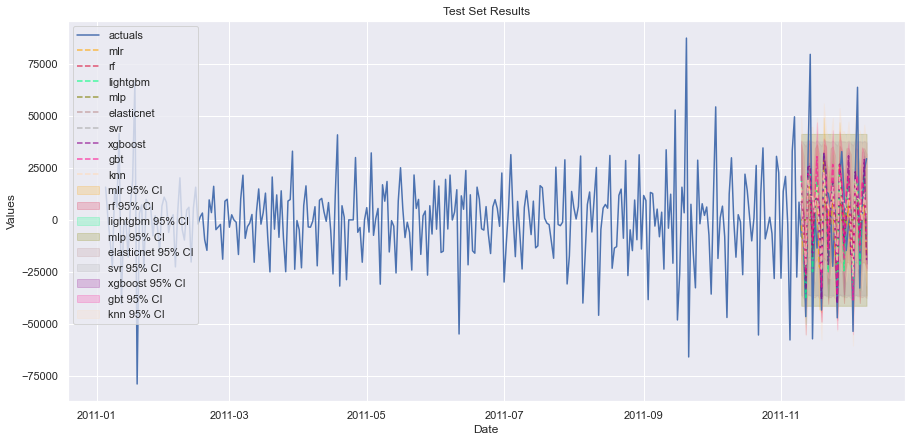

In [64]:
f.plot_test_set(order_by='LevelTestSetRMSE',models=_sklearn_estimators_,ci=True)

All of these models appear to have performed well on test-set data. Using a variety of models and tuning them carefully, a couple (or more) usually emerge as appearing reasonable to implement. Let's now see the forecasts and level test-set RMSE from all these models.

mlr LevelTestSetRMSE: 23569.349293218085
rf LevelTestSetRMSE: 29738.13072144908
lightgbm LevelTestSetRMSE: 30093.76927204383
mlp LevelTestSetRMSE: 31839.60750404216
elasticnet LevelTestSetRMSE: 32881.360865391776
svr LevelTestSetRMSE: 39533.677753185584
xgboost LevelTestSetRMSE: 61812.14921811586
gbt LevelTestSetRMSE: 80568.33133904717
knn LevelTestSetRMSE: 93490.9169451568


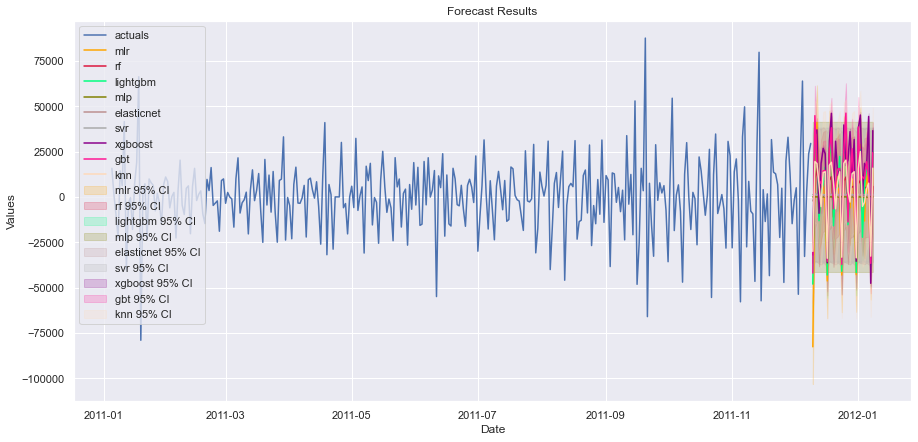

In [65]:
f.plot(models=_sklearn_estimators_,order_by='LevelTestSetRMSE',print_attr=['LevelTestSetRMSE'],ci=True)

Surprisingly perhaps, nothing outperformed the MLR model. And the MLR wasn't as good as the seasonal HWES model. Sometimes the simplest model is the best model. Let's see the forecasted plots for each model, but to avoid clutter, we focus on only the models that came out further ahead than the others. We pass the `models='top_5'` argument to this function and rerun. Note, now that the HWES model will not be displayed (which was run on level data), we will have to set `level=True` to view the forecasts at level.

hwes_seasonal LevelTestSetRMSE: 17518.624215169933
mlr LevelTestSetRMSE: 23569.349293218085
rf LevelTestSetRMSE: 29738.13072144908
lightgbm LevelTestSetRMSE: 30093.76927204383
mlp LevelTestSetRMSE: 31839.60750404216


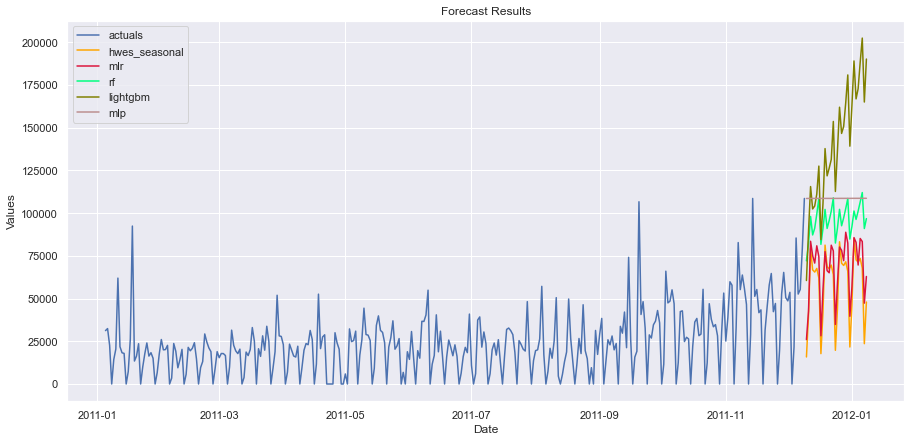

In [66]:
f.plot(models='top_5',order_by='LevelTestSetRMSE',print_attr=['LevelTestSetRMSE'],level=True)

These various patterns are interesting, and one has to believe the last value being high signficantly influenced the resulting trends of the lightGBM model.

### Prophet and Silverkite

[Back to top](#eCommerce-Example)  
In addition to the scikit-learn and statsmodels forecasting models we have already explored, two other forecasting models from popular libraries are available for use: Facebook [Prophet](https://facebook.github.io/prophet/) and LinkedIn Silverkite (from the [greykite](https://engineering.linkedin.com/blog/2021/greykite--a-flexible--intuitive--and-fast-forecasting-library) package). Prophet using a Bayesian regression approach with changepoints; Silverkite uses a linear model with regularization, also with changepoints. Calling them and using them are as easy as any other forecasting model in this package. The `Xvars` argument is available in both models--you can also tune them using the grid-search method. But, since they select a lot of their own regressors and optimize themselves by default, it is sometimes time-saving to manually forecast them with default parameters. We can also run them on un-differenced data and let them create their own regressors. Note, undifferencing the series deletes all added regressors.

In [67]:
f.undiff()
f

Forecaster(
    DateStartActuals=2011-01-04T00:00:00.000000000
    DateEndActuals=2011-12-09T00:00:00.000000000
    Freq=D
    ForecastLength=30
    Xvars=[]
    Differenced=0
    TestLength=30
    ValidationLength=15
    ValidationMetric=rmse
    ForecastsEvaluated=['hwes_seasonal', 'arima_ma_terms', 'mlr', 'elasticnet', 'gbt', 'knn', 'lightgbm', 'mlp', 'rf', 'svr', 'xgboost']
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=xgboost
)

In [68]:
f.set_estimator('prophet')
f.manual_forecast()

In [69]:
f.set_estimator('silverkite')
f.manual_forecast()
f.save_summary_stats()

Note, summary stats are available for silverkite but not Prophet -- contributions are welcome to get summary stats for Prophet.

After forecasting with Silverkite, we need to reset some matplotlib parameters for plotting to work.

In [70]:
matplotlib.use('nbAgg')
%matplotlib inline
sns.set(rc={'figure.figsize':(15,7)})

Let's see how these 2 new models performed compared with the top-2 models identified before.

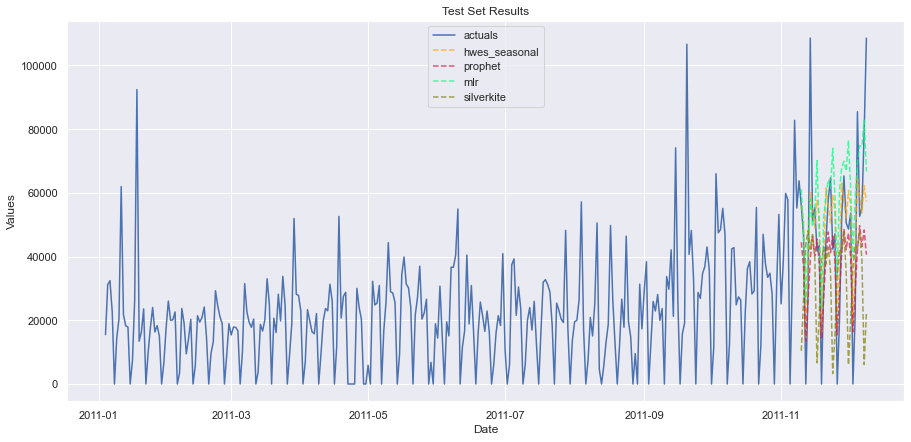

In [71]:
f.plot_test_set(models=['hwes_seasonal','mlr','prophet','silverkite'],order_by='LevelTestSetRMSE',level=True)

And their trends into the future:

hwes_seasonal LevelTestSetRMSE: 17518.624215169933
prophet LevelTestSetRMSE: 22691.837985385297
mlr LevelTestSetRMSE: 23569.349293218085
silverkite LevelTestSetRMSE: 35745.68851526046


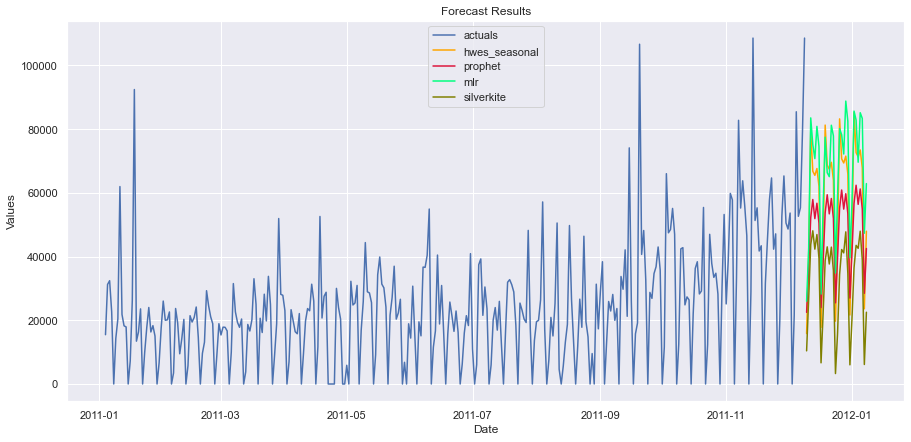

In [72]:
f.plot(models=['hwes_seasonal','mlr','prophet','silverkite'],order_by='LevelTestSetRMSE',print_attr=['LevelTestSetRMSE'],level=True)

Neither the prophet or silverkite models proved to be as accurate as the HWES model, but the Prophet did outperform MLR.

### TensorFlow Recurrent Neural Nets
[Back to top](#eCommerce-Example)  

The most advanced models available in scalecast are recurrent neural networks. There are two kinds: the SimpleRNN and the Long Short-Term Memory. The SimpleRNN, perhaps ironically, has the more complicated implementation in this framework. It allows for nearly all customization of the model that TensorFlow itselt would offer. What scalecast will do for you is preprocess the data correctly, scale all of the data when training the model, and unscale it appropriately to compare to any other models you run. It also tests the model on the same test set and bootsraps confidence intervals. The fact that it tests all the models also means it fits all the models twice, which can slow you down sometimes, but having two fits is also a blessing: **it really lets you know how generalizable your model is when new data is added.** Let's explore the SimpleRNN more carefully.

#### SimpleRNN
[Back to top](#eCommerce-Example)  

See the [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/_forecast.html#module-src.scalecast.Forecaster.Forecaster._forecast_rnn) for the 'rnn' estimator. In practice, calling this model looks like:

Epoch 1/15
7/7 [==============================] - 2s 39ms/step - loss: 0.2266 - val_loss: 0.1452
Epoch 2/15
7/7 [==============================] - 0s 9ms/step - loss: 0.1800 - val_loss: 0.1125
Epoch 3/15
7/7 [==============================] - 0s 10ms/step - loss: 0.1469 - val_loss: 0.0916
Epoch 4/15
7/7 [==============================] - 0s 9ms/step - loss: 0.1249 - val_loss: 0.0797
Epoch 5/15
7/7 [==============================] - 0s 9ms/step - loss: 0.1148 - val_loss: 0.0747
Epoch 6/15
7/7 [==============================] - 0s 10ms/step - loss: 0.1105 - val_loss: 0.0756
Epoch 7/15
7/7 [==============================] - 0s 9ms/step - loss: 0.1087 - val_loss: 0.0710
Epoch 8/15
7/7 [==============================] - 0s 9ms/step - loss: 0.1043 - val_loss: 0.0673
Epoch 9/15
7/7 [==============================] - 0s 10ms/step - loss: 0.1014 - val_loss: 0.0697
Epoch 10/15
7/7 [==============================] - 0s 10ms/step - loss: 0.0994 - val_loss: 0.0685
Epoch 11/15
7/7 [=================

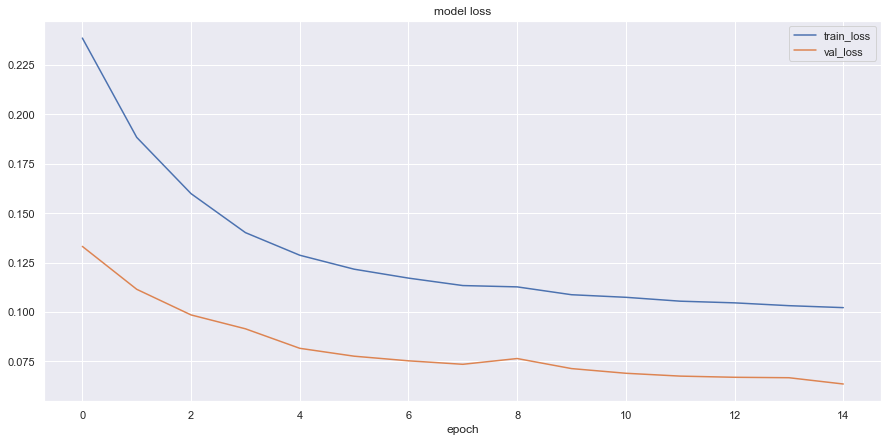

Epoch 1/15
7/7 [==============================] - 2s 69ms/step - loss: 0.2016 - val_loss: 0.1388
Epoch 2/15
7/7 [==============================] - 0s 16ms/step - loss: 0.1655 - val_loss: 0.0972
Epoch 3/15
7/7 [==============================] - 0s 14ms/step - loss: 0.1362 - val_loss: 0.0829
Epoch 4/15
7/7 [==============================] - 0s 13ms/step - loss: 0.1232 - val_loss: 0.0764
Epoch 5/15
7/7 [==============================] - 0s 14ms/step - loss: 0.1185 - val_loss: 0.0756
Epoch 6/15
7/7 [==============================] - 0s 16ms/step - loss: 0.1173 - val_loss: 0.0752
Epoch 7/15
7/7 [==============================] - 0s 17ms/step - loss: 0.1169 - val_loss: 0.0748
Epoch 8/15
7/7 [==============================] - 0s 16ms/step - loss: 0.1167 - val_loss: 0.0739
Epoch 9/15
7/7 [==============================] - 0s 17ms/step - loss: 0.1166 - val_loss: 0.0743
Epoch 10/15
7/7 [==============================] - 0s 18ms/step - loss: 0.1161 - val_loss: 0.0734
Epoch 11/15
7/7 [============

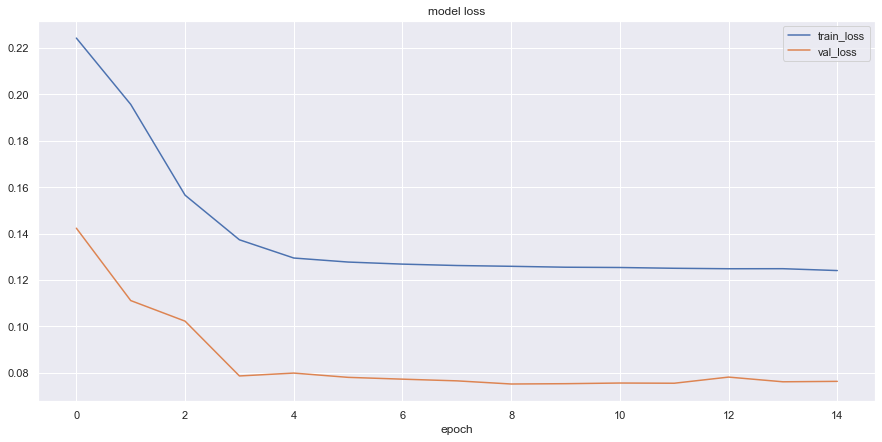

In [73]:
f.set_estimator('rnn')
f.manual_forecast(lags=30,
                  hidden_layers_struct={'simple':{'units':64},'simple':{'units':64},'simple':{'units':64}},
                  validation_split=0.2,
                  epochs=15,
                  plot_loss=True,
                  call_me='simple_rnn')

f.manual_forecast(lags=30,
                  hidden_layers_struct={'lstm':{'units':64},'lstm':{'units':64},'lstm':{'units':64}},
                  validation_split=0.2,
                  epochs=15,
                  plot_loss=True,
                  call_me='lstm')

Anything the lstm can do in scalecast, the rnn can also do. Using the lstm estimator instead of rnn is simpler, and that is explored below.

#### LSTM
[Back to top](#eCommerce-Example)  

See the [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/_forecast.html#module-src.scalecast.Forecaster.Forecaster._forecast_lstm) for the 'lstm' estimator. There are more parameters to explicitly specify, but that makes it a lot easier to navigate as well. In practice, calling this model looks like:

Epoch 1/15
7/7 [==============================] - 5s 181ms/step - loss: 0.1978 - val_loss: 0.1181
Epoch 2/15
7/7 [==============================] - 0s 34ms/step - loss: 0.1474 - val_loss: 0.0852
Epoch 3/15
7/7 [==============================] - 0s 33ms/step - loss: 0.1245 - val_loss: 0.0804
Epoch 4/15
7/7 [==============================] - 0s 32ms/step - loss: 0.1206 - val_loss: 0.0766
Epoch 5/15
7/7 [==============================] - 0s 34ms/step - loss: 0.1183 - val_loss: 0.0768
Epoch 6/15
7/7 [==============================] - 0s 35ms/step - loss: 0.1181 - val_loss: 0.0745
Epoch 7/15
7/7 [==============================] - 0s 39ms/step - loss: 0.1177 - val_loss: 0.0744
Epoch 8/15
7/7 [==============================] - 0s 36ms/step - loss: 0.1179 - val_loss: 0.0764
Epoch 9/15
7/7 [==============================] - 0s 33ms/step - loss: 0.1183 - val_loss: 0.0761
Epoch 10/15
7/7 [==============================] - 0s 34ms/step - loss: 0.1178 - val_loss: 0.0745
Epoch 11/15
7/7 [===========

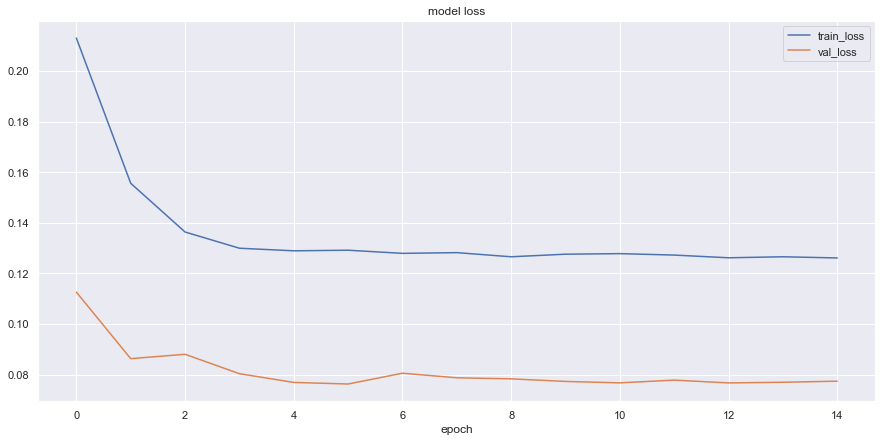

In [74]:
f.set_estimator('lstm')
f.manual_forecast(lags=30,
                  lstm_layer_sizes=(64,64,64),
                  dropout=(0.2,0,0),
                  validation_split=0.2,
                  epochs=15,
                  plot_loss=True,
                  call_me='lstm_regularized')

Finally, we can see how all these models performed on the test set:

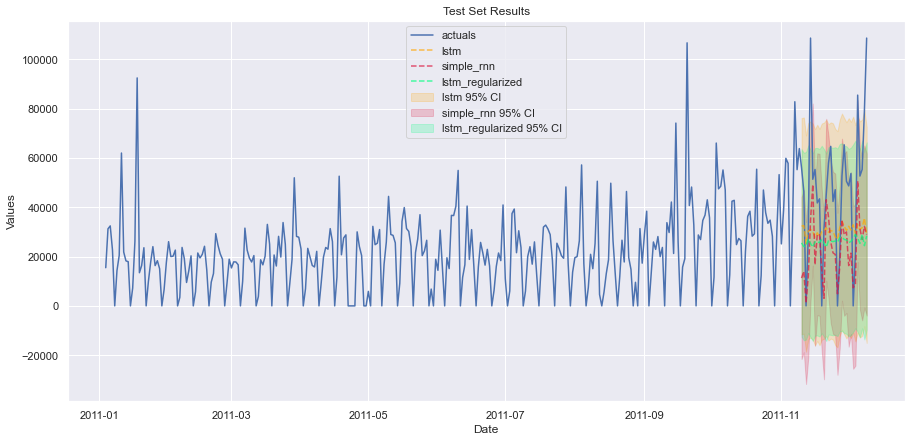

In [75]:
f.plot_test_set(models=['simple_rnn','lstm','lstm_regularized'],ci=True,order_by='LevelTestSetRMSE')

And into the future:

lstm LevelTestSetRMSE: 31215.2736700929
simple_rnn LevelTestSetRMSE: 31726.259771925106
lstm_regularized LevelTestSetRMSE: 34271.8439855535


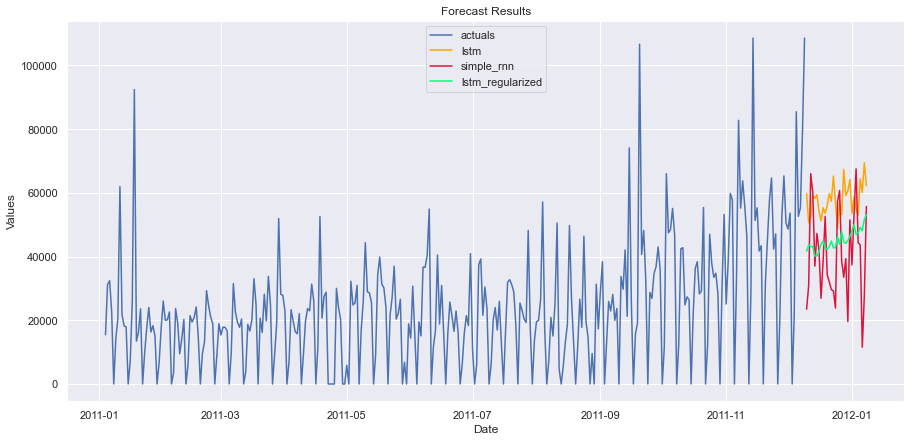

In [76]:
f.plot(models=['simple_rnn','lstm','lstm_regularized'],ci=True,order_by='LevelTestSetRMSE',level=True,print_attr=['LevelTestSetRMSE'])

None of these models arrived at the level of the MLR or HWES models. That's not to say they couldn't if more time weren't spent with them. Theoretically, they can specify thousands of parameters and find the true long-term trends in the data that none of the other models would be capable of. For some datasets, this makes a big difference. But some datasets are too random to be fit effectively by one of these more advanced models. Sometimes the simplest is most accurate, fastest, and most interpretable. That being said, all of these models probably could have benefited from more training epochs.

### Combination Modeling

[Back to top](#eCommerce-Example)  
The last model concept we will explore is combination modeling. There are three types of combinations:
- simple: a simple average of a group of models.
- weighted: a weighted average of a group of models. Weights can be passed manually (as we do below) or set automatically based on a metric passed to the `determine_best_by` parameter.
- splice: a splice of two or more models at one or more future splice points. All metrics, fitted values, and test-set metrics from this model will be identical to the simple average.

We will be using simple and weighted average combination modeling only.

In [78]:
f.set_estimator('combo')
f.manual_forecast(how='simple',models=['hwes_seasonal','arima_ma_terms','prophet','silverkite','simple_rnn','lstm','lstm_regularized'],call_me='avg_lvl_models')
f.manual_forecast(how='weighted',models=_sklearn_estimators_,determine_best_by='ValidationMetricValue',call_me='weighted_differenced_models')

It could be argued that combination modeling is prone to problems related to data leakage--we shouldn't select model combinations based based on their performance on the test set and then recompare them to the test set. By default, deterimine_best_by in both of these combination types is `'ValidationMetricValue'`. This is a way to ensure data leakage does not occur. Since we didn't tune all the models we want to combine in the first function, we simply write out the models we want to combine in a list.

The weighted average model can accept weights as arguments that add to 0 or not--if not, they will be rebalanced to do so. If determine_best_by is specified, weights can be left to None and the weights will be chosen automatically. Again, be careful to not overfit models this way.

All information available for other models, including fitted values and test-set metrics, are also available for these combo models.

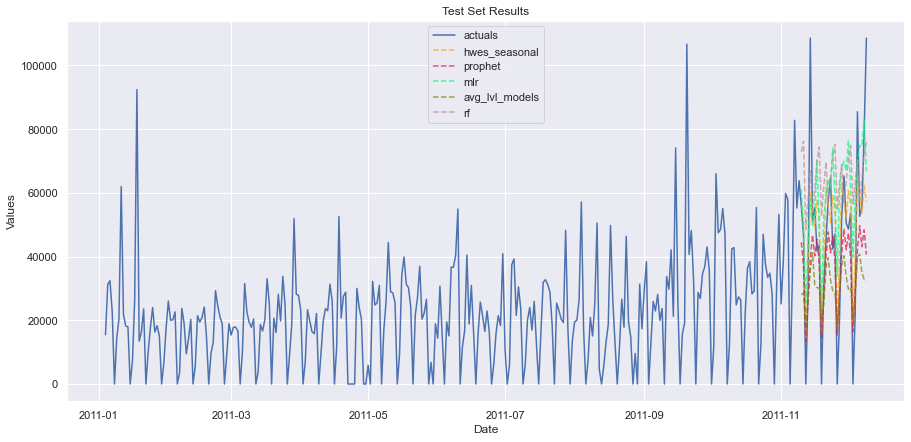

In [79]:
f.plot_test_set(models='top_5',order_by='LevelTestSetRMSE',level=True)

Again, we see the usual suspects. One more time on future data:

hwes_seasonal LevelTestSetRMSE: 17518.624215169933
prophet LevelTestSetRMSE: 22691.837985385297
mlr LevelTestSetRMSE: 23569.349293218085
avg_lvl_models LevelTestSetRMSE: 28024.451781745036
rf LevelTestSetRMSE: 29738.13072144908


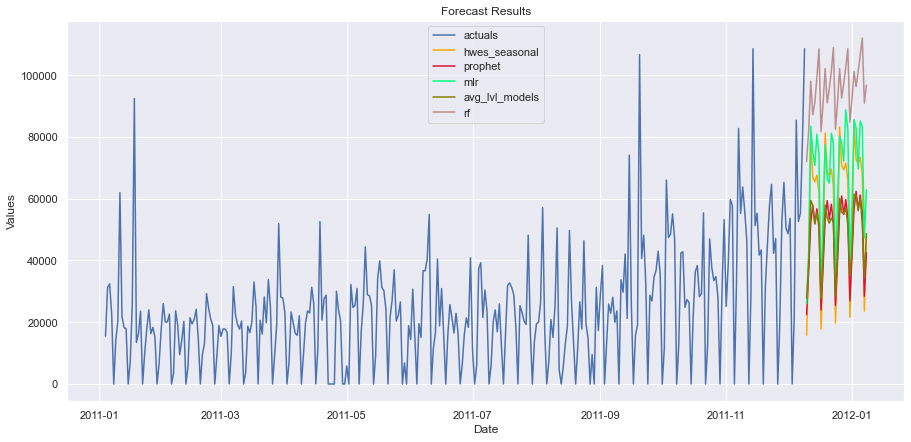

In [80]:
f.plot(models='top_5',order_by='LevelTestSetRMSE',print_attr=['LevelTestSetRMSE'],level=True)

And just as a grand finale, let's see all evaluated models plotted together:

hwes_seasonal LevelTestSetRMSE: 17518.624215169933
prophet LevelTestSetRMSE: 22691.837985385297
mlr LevelTestSetRMSE: 23569.349293218085
avg_lvl_models LevelTestSetRMSE: 28024.451781745036
rf LevelTestSetRMSE: 29738.13072144908
lightgbm LevelTestSetRMSE: 30093.76927204383
lstm LevelTestSetRMSE: 31215.2736700929
simple_rnn LevelTestSetRMSE: 31726.259771925106
mlp LevelTestSetRMSE: 31839.60750404216
elasticnet LevelTestSetRMSE: 32881.360865391776
lstm_regularized LevelTestSetRMSE: 34271.8439855535
silverkite LevelTestSetRMSE: 35745.68851526046
arima_ma_terms LevelTestSetRMSE: 37348.542960036495
svr LevelTestSetRMSE: 39533.677753185584
weighted_differenced_models LevelTestSetRMSE: 52146.394940336766
xgboost LevelTestSetRMSE: 61812.14921811586
gbt LevelTestSetRMSE: 80568.33133904717
knn LevelTestSetRMSE: 93490.9169451568


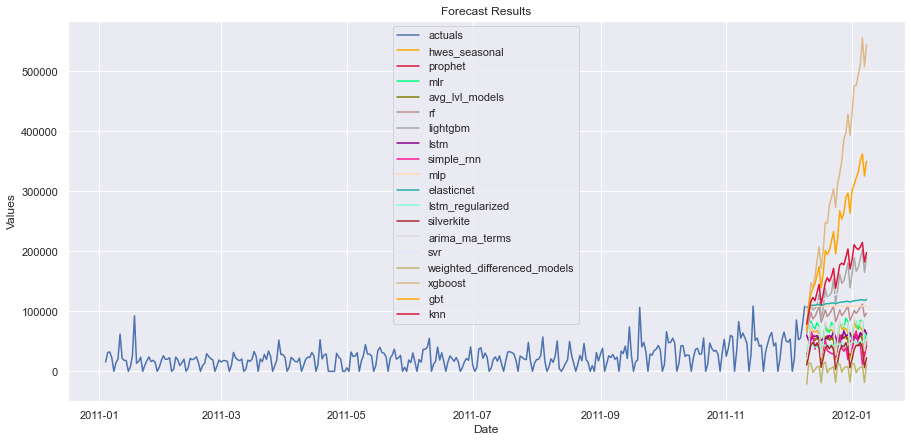

In [81]:
f.plot(order_by='LevelTestSetRMSE',print_attr=['LevelTestSetRMSE'],level=True)

## Export Results

[Back to top](#eCommerce-Example)  
Now that we have models that offer interesting ranges of predictions (and a few that look pretty bad), let's export all available results to Excel to view later. The first function below exports a workbook with five tabs that offer information including forecasted values, level forecasted values, descriptive information about each model, and test-set prediction. The second two functions export feature info and validation grids, and they have to_excel in the method name because they automatically put each model's info on a seperate tab.

In [82]:
results = f.export(to_excel=True,determine_best_by='LevelTestSetRMSE',excel_name='eCommerce_results.xlsx')
f.all_feature_info_to_excel(excel_name='eCommerce_feature_info.xlsx') 
f.all_validation_grids_to_excel(sort_by_metric_value=True,excel_name='eCommerce_validation_grids.xlsx')

One of the most interesting of the exports above is the model summaries dataframe. It has many columns that you can view in the exported Excel workbook, but a sample of this dataframe is displayed below.

In [83]:
results['model_summaries'][['ModelNickname','Estimator','HyperParams','LevelTestSetRMSE','LevelTestSetR2']]

,ModelNickname,Estimator,HyperParams,LevelTestSetRMSE,LevelTestSetR2
0,hwes_seasonal,hwes,"{'trend': 'add', 'seasonal': 'add'}",17518.624215,0.582864
1,prophet,prophet,{},22691.837985,0.300130
2,mlr,mlr,{},23569.349293,0.244955
3,avg_lvl_models,combo,"{'how': 'simple', 'models': ['hwes_seasonal', ...",28024.451782,-0.067461
4,rf,rf,"{'max_depth': 2, 'n_estimators': 500}",29738.130721,-0.202002
5,lightgbm,lightgbm,{'max_depth': 3},30093.769272,-0.230924
6,lstm,rnn,"{'lags': 30, 'hidden_layers_struct': {'lstm': ...",31215.273670,-0.324379
7,simple_rnn,rnn,"{'lags': 30, 'hidden_layers_struct': {'simple'...",31726.259772,-0.368093
8,mlp,mlp,"{'activation': 'tanh', 'hidden_layer_sizes': (...",31839.607504,-0.377886
9,elasticnet,elasticnet,"{'alpha': 2.0, 'l1_ratio': 0.0}",32881.360865,-0.469527


Here is a list of all export functions. Most of these output results to a pandas dataframe.

In [84]:
print(*f.get_funcs('exporter'),sep='\n')

export
export_summary_stats
export_feature_importance
export_validation_grid
all_feature_info_to_excel
all_validation_grids_to_excel
export_Xvars_df
export_forecasts_with_cis
export_test_set_preds_with_cis
export_fitted_vals
